#Setup

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',  force_remount=True)
os.chdir('/content/drive/MyDrive/Experiments/')

Mounted at /content/drive


#Define callback for recording training times

In [ ]:
from timeit import default_timer as timer
import keras
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

tcb = TimingCallback()

#sBERT (Proposed Model)

## Model Definition

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from util import ㅤload_WOS,  load_glove_embeddings,  create_embeddings_matrix
#Implement a Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, word_index):
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim


        #Toekem embedding loaded from glove

        embeddings_index = load_glove_embeddings(embed_dim)
        embeddings_matrix, found = create_embeddings_matrix(embeddings_index, word_index, embed_dim)

        super(TokenAndPositionEmbedding, self).__init__()



        #define position embedding
        def getPositionEncoding(seq_len, d, n=10000):
          P = np.zeros((seq_len, d))
          for k in range(seq_len):
              for i in np.arange(int(d/2)):
                  denominator = np.power(n, 2*i/d)
                  P[k, 2*i] = np.sin(k/denominator)
                  P[k, 2*i+1] = np.cos(k/denominator)
          return P

        self.token_emb = layers.Embedding(input_dim = embeddings_matrix.shape[0], output_dim=embed_dim, weights = [embeddings_matrix], trainable = True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, weights = [getPositionEncoding(maxlen, embed_dim)], trainable=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config


def create_model(emb_dim, n_blocks, n_heads, ff_dim, maxlen, vocab_size, nClasses, word_index):
  #print('Model : emb_dim = ', emb_dim, ', n_heads = ', n_heads, ', ff_dim = ', ff_dim)
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, emb_dim, word_index)
  x = embedding_layer(inputs)
  for i in range(n_blocks):
    transformer_block = TransformerBlock(emb_dim, n_heads, ff_dim)
    x = transformer_block(x)
  #x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(nClasses, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract training and validation metrics from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    epochs = range(1, len(training_loss) + 1)

    # Create a pretty plot
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r*-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r*-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming you have a `history` object from model.fit() or similar
# plot_history(history)


In [ ]:
print(range(1, 4 + 1)[:])

range(1, 5)


# New section

##WOS Datasets




WOS5736
Training..
Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.6520
Epoch 1: val_accuracy improved from -inf to 0.84582, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS5736.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 51s 128ms/step - loss: 0.7468 - accuracy: 0.6520 - val_loss: 0.3372 - val_accuracy: 0.8458
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9297
Epoch 2: val_accuracy improved from 0.84582 to 0.96777, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS5736.h5
359/359 [==============================] - 20s 55ms/step - loss: 0.2081 - accuracy: 0.9297 - val_loss: 0.0974 - val_accuracy: 0.9678
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.96777 to 0.99390, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS5736.h5
359/359 [==============================] - 19s 53ms/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0.0257 - val_accuracy: 0.9939
Epoch 4/10
359/359 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9855
Epoch 4: val_accuracy improved from 0.99390 to 0.99477, saving model

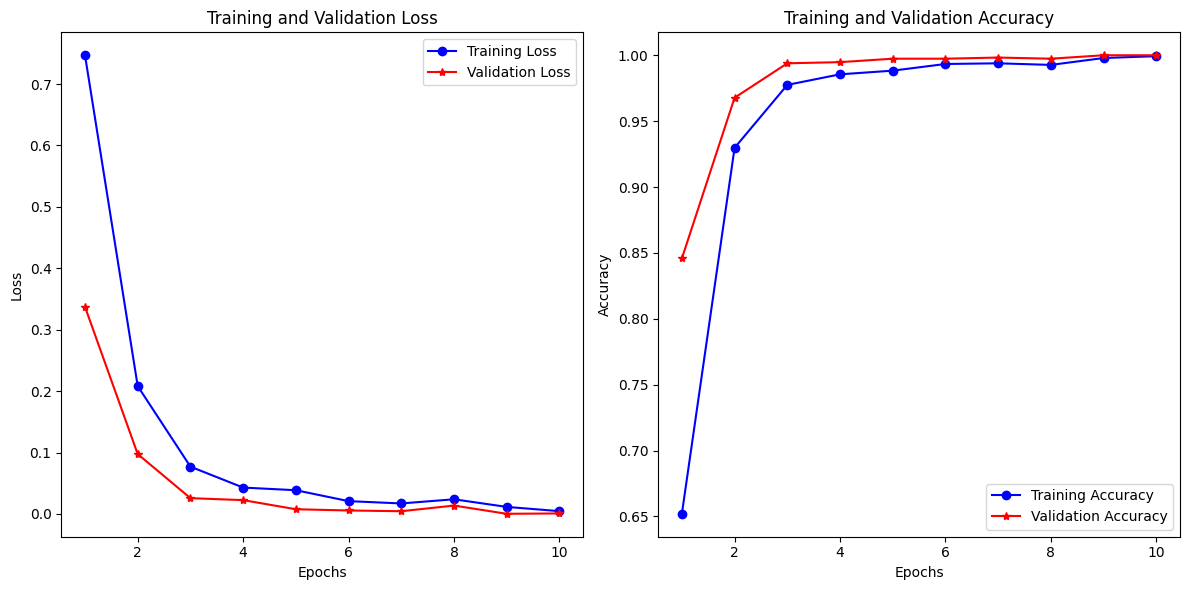

36/36 [==============================] - 1s 18ms/step - loss: 2.2544e-04 - accuracy: 1.0000
{'loss': 0.00022544091916643083, 'accuracy': 1.0}



WOS11967
Training..
Epoch 1/10
748/748 [==============================] - ETA: 0s - loss: 1.5740 - accuracy: 0.3642
Epoch 1: val_accuracy improved from -inf to 0.68177, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS11967.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


748/748 [==============================] - 67s 83ms/step - loss: 1.5740 - accuracy: 0.3642 - val_loss: 0.8554 - val_accuracy: 0.6818
Epoch 2/10
746/748 [============================>.] - ETA: 0s - loss: 0.5812 - accuracy: 0.8101
Epoch 2: val_accuracy improved from 0.68177 to 0.90177, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS11967.h5
748/748 [==============================] - 27s 36ms/step - loss: 0.5807 - accuracy: 0.8104 - val_loss: 0.3319 - val_accuracy: 0.9018
Epoch 3/10
747/748 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8895
Epoch 3: val_accuracy improved from 0.90177 to 0.93772, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS11967.h5
748/748 [==============================] - 24s 32ms/step - loss: 0.3489 - accuracy: 0.8894 - val_loss: 0.2135 - val_accuracy: 0.9377
Epoch 4/10
747/748 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9265
Epoch 4: val_accuracy improved from 0.93772 to 0.95873, saving mode

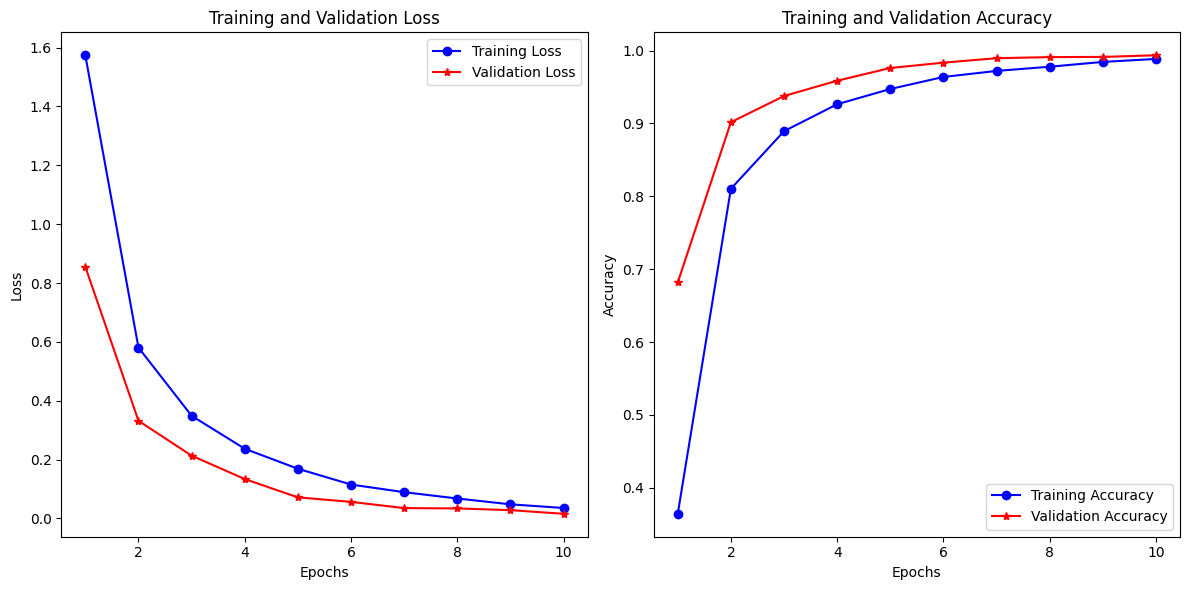

124/124 [==============================] - 2s 18ms/step - loss: 0.0159 - accuracy: 0.9937
{'loss': 0.015888193622231483, 'accuracy': 0.9936708807945251}



WOS46985
Training..
Epoch 1/10
2937/2937 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.6179
Epoch 1: val_accuracy improved from -inf to 0.82510, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS46985.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2937/2937 [==============================] - 167s 49ms/step - loss: 1.0182 - accuracy: 0.6179 - val_loss: 0.5111 - val_accuracy: 0.8251
Epoch 2/10
2937/2937 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8356
Epoch 2: val_accuracy improved from 0.82510 to 0.88172, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS46985.h5
2937/2937 [==============================] - 93s 32ms/step - loss: 0.4848 - accuracy: 0.8356 - val_loss: 0.3485 - val_accuracy: 0.8817
Epoch 3/10
2937/2937 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.8777
Epoch 3: val_accuracy improved from 0.88172 to 0.91623, saving model to saved_models6/sBERT_1_100_12_256_20000_WOS46985.h5
2937/2937 [==============================] - 94s 32ms/step - loss: 0.3626 - accuracy: 0.8777 - val_loss: 0.2495 - val_accuracy: 0.9162
Epoch 4/10
2937/2937 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.9067
Epoch 4: val_accuracy improved from 0.91623 to 0.94634

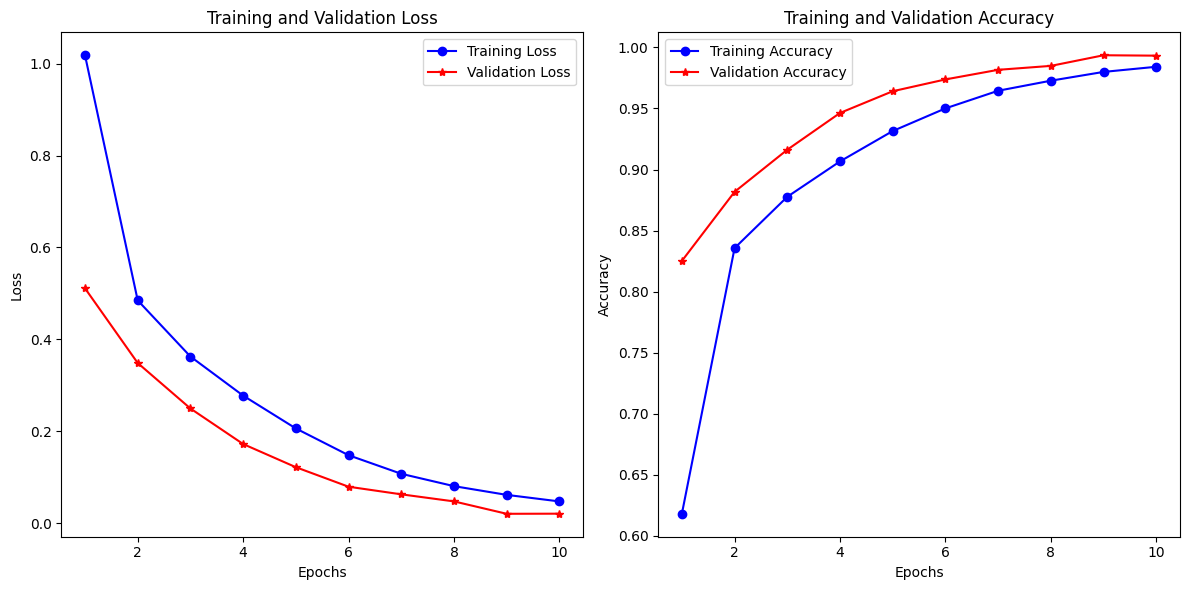

485/485 [==============================] - 8s 17ms/step - loss: 0.0203 - accuracy: 0.9936
{'loss': 0.02034785971045494, 'accuracy': 0.9936153888702393}


In [ ]:
from util import load_WOS, load_slc
from keras.models import load_model
import pandas as pd
import numpy as np
import os
import keras

vocab_size = 20000 #20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each abstract
emb_dim = 100
n_blocks = 1
n_heads = 12
ff_dim = 256
batchsize = 16
num_epochs = 100
save_dir = 'saved_models6/'
test = False

model_name = 'sBERT_' + str(n_blocks) + '_' + str(emb_dim) + '_' +  str(n_heads) + '_' +  str(ff_dim) + '_' + str(vocab_size)
for dsname in  ["WOS5736",  "WOS11967", "WOS46985"]:#
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)
  if 'WOS' in dsname:
    x_train, Y_train, x_test, Y_test,  word_index, nClasses  = ㅤload_WOS(dsname, vocab_size, maxlen)
  else:
    x_train, Y_train, x_test, Y_test,  word_index, nClasses  =   load_slc(dsname, maxlen, vocab_size)
  def get_model_name(model_name, dsname):
      return model_name + '_' + dsname + '.h5'
  model = create_model(emb_dim, n_blocks, n_heads, ff_dim, maxlen, vocab_size, nClasses, word_index)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=8)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir + get_model_name(model_name, dsname), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()
    callbacks_list = [tcb, checkpoint, es]
    print("Training..")
    history = model.fit(x_train, Y_train,
          epochs=10,
          batch_size = batchsize,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test),
          verbose = 1)
    plot_history(history)
    history.history["time"]=tcb.logs
    import pickle
    with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)


In [ ]:
history.history["time"]=tcb.logs

In [ ]:
history.history

In [ ]:
import pandas as pd
df = pd.DataFrame(history)
df.head(10)

,loss,accuracy,val_loss,val_accuracy
0,1.007676,0.622305,0.502879,0.826648
1,0.488389,0.837565,0.376323,0.871340
2,0.371106,0.875769,0.273418,0.904682
3,0.284335,0.904395,0.195196,0.932607
4,0.209179,0.930169,0.132398,0.957113
5,0.149295,0.951900,0.086031,0.973946
6,0.104904,0.965180,0.057433,0.979556
7,0.080277,0.973609,0.037807,0.989230
8,0.059820,0.980292,0.037142,0.987489
9,0.049005,0.983782,0.022046,0.993680


In [ ]:
with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'rb') as file_pi:
    history = pickle.load(file_pi)

##Created Datasets




arxiv
Training..
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.82988, saving model to saved_models6/sBERT_1_100_12_256_20000_arxiv.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2003/2003 - 108s - loss: 0.9804 - accuracy: 0.6465 - val_loss: 0.5472 - val_accuracy: 0.8299 - 108s/epoch - 54ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.82988 to 0.85372, saving model to saved_models6/sBERT_1_100_12_256_20000_arxiv.h5
2003/2003 - 59s - loss: 0.4718 - accuracy: 0.8510 - val_loss: 0.4575 - val_accuracy: 0.8537 - 59s/epoch - 30ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.85372
2003/2003 - 50s - loss: 0.3367 - accuracy: 0.8916 - val_loss: 0.4472 - val_accuracy: 0.8528 - 50s/epoch - 25ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.85372 to 0.86283, saving model to saved_models6/sBERT_1_100_12_256_20000_arxiv.h5
2003/2003 - 54s - loss: 0.2441 - accuracy: 0.9192 - val_loss: 0.4880 - val_accuracy: 0.8628 - 54s/epoch - 27ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.86283
2003/2003 - 49s - loss: 0.1700 - accuracy: 0.9446 - val_loss: 0.6198 - val_accuracy: 0.8430 - 49s/epoch - 25ms/step
Epoch 6/10

Epoch 6: val_acc

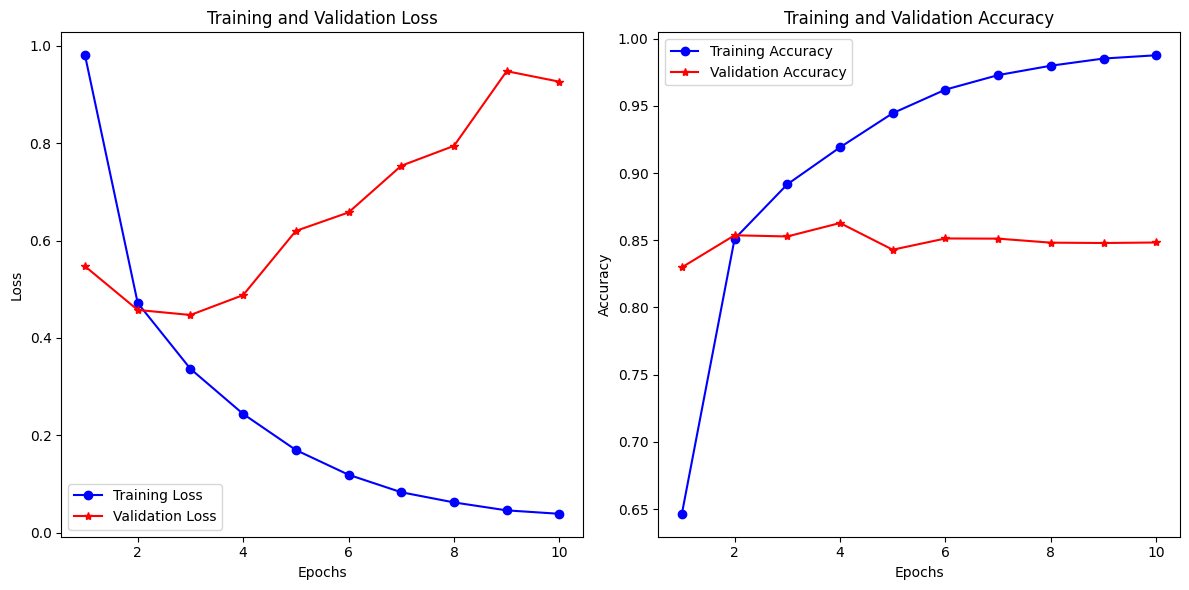

251/251 [==============================] - 4s 16ms/step - loss: 0.4880 - accuracy: 0.8628
{'loss': 0.48801475763320923, 'accuracy': 0.8628307580947876}



springer
Training..
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.99931, saving model to saved_models6/sBERT_1_100_12_256_20000_springer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5812/5812 - 200s - loss: 0.3567 - accuracy: 0.8951 - val_loss: 0.0044 - val_accuracy: 0.9993 - 200s/epoch - 34ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.99931
5812/5812 - 146s - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.0083 - val_accuracy: 0.9975 - 146s/epoch - 25ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.99931 to 0.99983, saving model to saved_models6/sBERT_1_100_12_256_20000_springer.h5
5812/5812 - 140s - loss: 0.0104 - accuracy: 0.9974 - val_loss: 8.0940e-04 - val_accuracy: 0.9998 - 140s/epoch - 24ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.99983 to 1.00000, saving model to saved_models6/sBERT_1_100_12_256_20000_springer.h5
5812/5812 - 143s - loss: 0.0087 - accuracy: 0.9980 - val_loss: 3.7513e-06 - val_accuracy: 1.0000 - 143s/epoch - 25ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 1.00000
5812/5812 - 143s - loss: 5.3036e-06 - accuracy: 1.0000 - val_loss: 1.7487e-09 - val_accuracy: 1.0000 - 143s/epoch - 25ms/ste

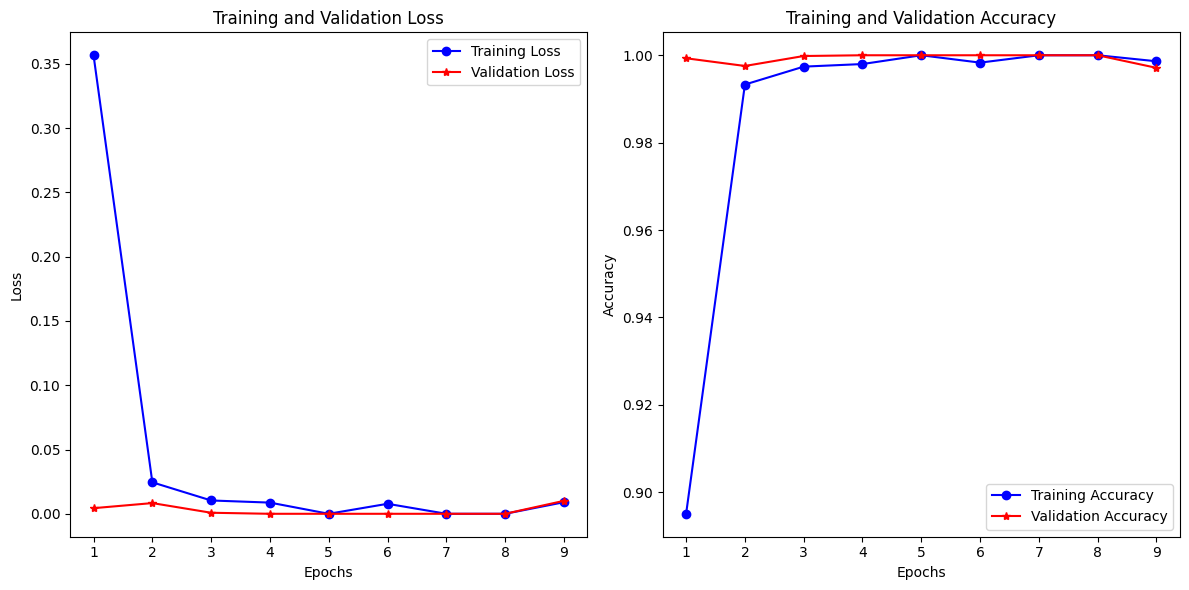

727/727 [==============================] - 12s 16ms/step - loss: 3.7513e-06 - accuracy: 1.0000
{'loss': 3.75130184693262e-06, 'accuracy': 1.0}



nature
Training..
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.53029, saving model to saved_models6/sBERT_1_100_12_256_20000_nature.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1556/1556 - 94s - loss: 1.5363 - accuracy: 0.4224 - val_loss: 1.2622 - val_accuracy: 0.5303 - 94s/epoch - 61ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.53029 to 0.57721, saving model to saved_models6/sBERT_1_100_12_256_20000_nature.h5
1556/1556 - 48s - loss: 1.1190 - accuracy: 0.5937 - val_loss: 1.1205 - val_accuracy: 0.5772 - 48s/epoch - 31ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.57721 to 0.58220, saving model to saved_models6/sBERT_1_100_12_256_20000_nature.h5
1556/1556 - 49s - loss: 0.9567 - accuracy: 0.6391 - val_loss: 1.1062 - val_accuracy: 0.5822 - 49s/epoch - 31ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.58220 to 0.58525, saving model to saved_models6/sBERT_1_100_12_256_20000_nature.h5
1556/1556 - 47s - loss: 0.8525 - accuracy: 0.6714 - val_loss: 1.1032 - val_accuracy: 0.5852 - 47s/epoch - 30ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.58525
1556/1556 - 42s - loss: 0.7790 - accuracy: 0.6892 - val_loss: 1.1649 - val

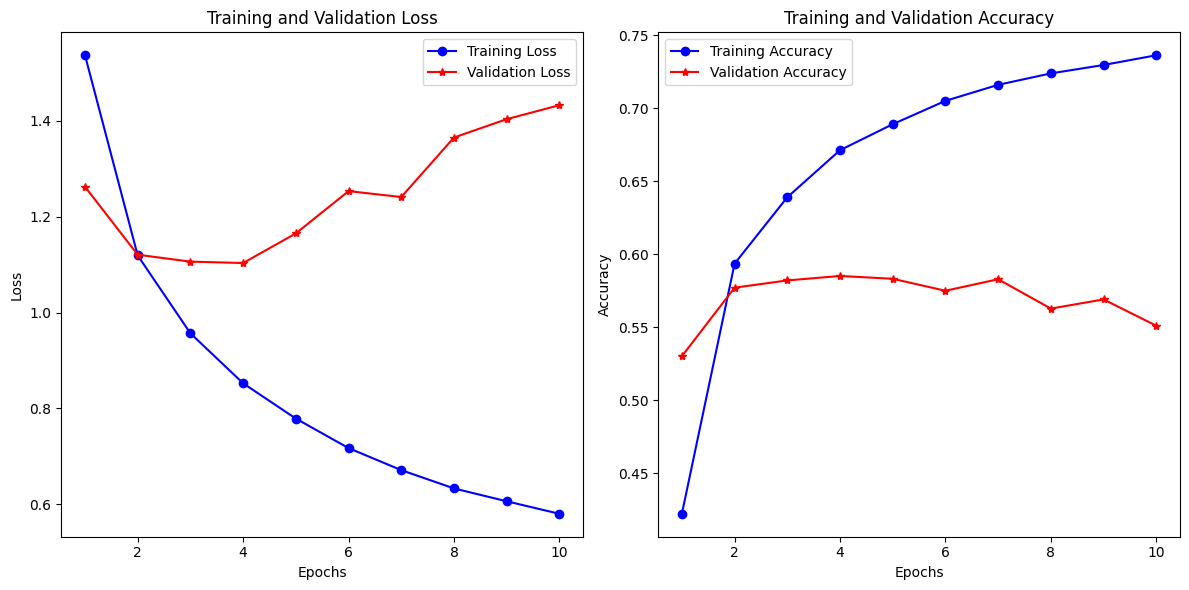

195/195 [==============================] - 3s 17ms/step - loss: 1.1032 - accuracy: 0.5852
{'loss': 1.1031991243362427, 'accuracy': 0.5852482914924622}



wiley
Training..
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.48440, saving model to saved_models6/sBERT_1_100_12_256_20000_wiley.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8998/8998 - 317s - loss: 2.6463 - accuracy: 0.2795 - val_loss: 1.7039 - val_accuracy: 0.4844 - 317s/epoch - 35ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.48440 to 0.60596, saving model to saved_models6/sBERT_1_100_12_256_20000_wiley.h5
8998/8998 - 243s - loss: 1.4341 - accuracy: 0.5494 - val_loss: 1.1604 - val_accuracy: 0.6060 - 243s/epoch - 27ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.60596 to 0.65661, saving model to saved_models6/sBERT_1_100_12_256_20000_wiley.h5
8998/8998 - 240s - loss: 1.0523 - accuracy: 0.6404 - val_loss: 0.9509 - val_accuracy: 0.6566 - 240s/epoch - 27ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.65661 to 0.68609, saving model to saved_models6/sBERT_1_100_12_256_20000_wiley.h5
8998/8998 - 245s - loss: 0.8751 - accuracy: 0.6839 - val_loss: 0.8315 - val_accuracy: 0.6861 - 245s/epoch - 27ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.68609 to 0.69915, saving model to saved_models6/sBERT_1_100_12_256_20000_wiley.h5


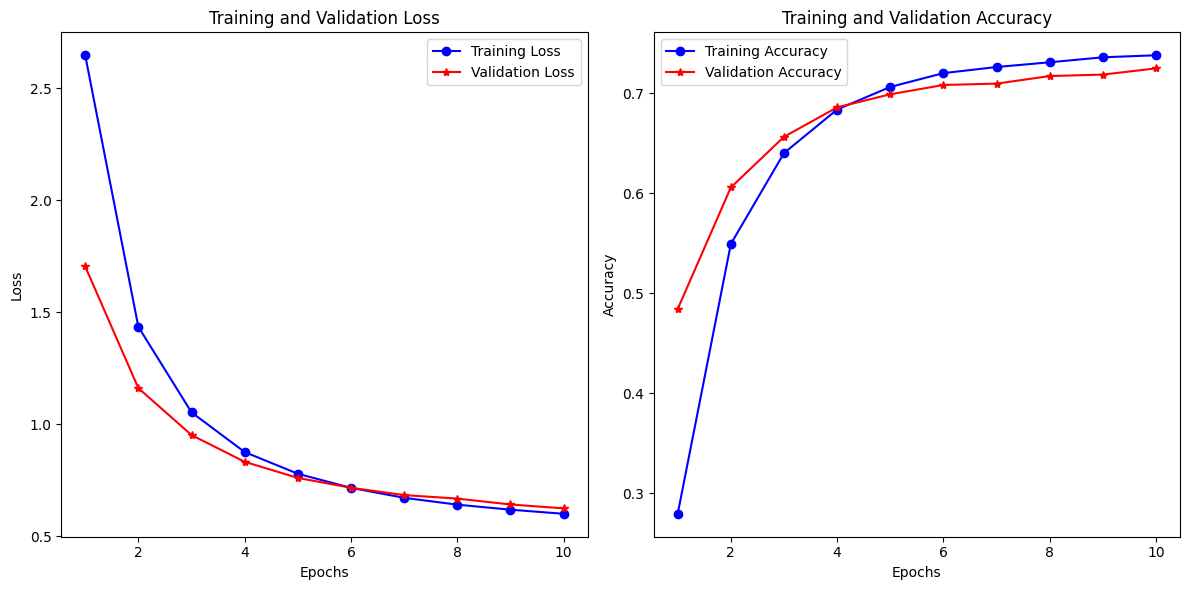

1125/1125 [==============================] - 20s 18ms/step - loss: 0.6236 - accuracy: 0.7251
{'loss': 0.6236346364021301, 'accuracy': 0.7250701785087585}


In [ ]:
from util import load_WOS, load_slc
from keras.models import load_model
import pandas as pd
import numpy as np
import os
import keras

vocab_size = 20000 #20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each abstract
emb_dim = 100
n_blocks = 1
n_heads = 12
ff_dim = 256
batchsize = 16
num_epochs = 10
save_dir = 'saved_models6/'
test = False

model_name = 'sBERT_' + str(n_blocks) + '_' + str(emb_dim) + '_' +  str(n_heads) + '_' +  str(ff_dim) + '_' + str(vocab_size)
for dsname in  [ "arxiv", "springer", "nature", "wiley"]: #,
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)
  x_train, Y_train, x_test, Y_test,  word_index, nClasses  =   load_slc(dsname, maxlen, vocab_size)
  def get_model_name(model_name, dsname):
      return model_name + '_' + dsname + '.h5'
  model = create_model(emb_dim, n_blocks, n_heads, ff_dim, maxlen, vocab_size, nClasses, word_index)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=8)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir + get_model_name(model_name, dsname), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()
    callbacks_list = [checkpoint, es]
    '''
    if os.path.exists(save_dir + get_model_name(model_name, dsname)):
      print("Initializing weights from saved model..")
      model.load_weights(save_dir + get_model_name(model_name, dsname))
      print("Initialized!")
    '''

    print("Training..")
    history = model.fit(x_train, Y_train,
          epochs=10,
          batch_size = batchsize,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test),
          verbose = 2 )
    plot_history(history)
    history.history["time"]=tcb.logs

    import pickle
    with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)

In [ ]:
tcb.logs



[63.62793636099997,
 21.052922432000003,
 14.420476870000016,
 13.106046689999971,
 13.895536210999978,
 11.375112446000003,
 10.095852578000006,
 10.67779084099999,
 10.394715440000027,
 11.373875859999998,
 84.390444516,
 28.73601759999997,
 23.300470888000063,
 58.706481247000056,
 21.816614142999924,
 17.93901924099987,
 12.468816672000003,
 12.197408677999874,
 10.653529022000157,
 9.997316798999918,
 9.262823436999952,
 9.976184123999928,
 11.320706608999899,
 66.716896184,
 26.486594481999873,
 22.72663285700014,
 25.378753923999966,
 23.247530190000134,
 22.237184064000076,
 20.635139082000023,
 20.58817686999987,
 20.377801550999948,
 21.345900530000108,
 165.0693439869999,
 88.69438785699981,
 89.79429155599996,
 87.03261414099984,
 86.37533739399987,
 86.67288013100006,
 86.49100410099982,
 85.63117420400022,
 87.70341189700002,
 86.34944426300035]

In [ ]:
with open('saved_models6/sBERT_1_100_12_256_20000_wiley_trainHistoryDict', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [ ]:
!ls saved_models6

cnn_kim_cornell.h5
htltexCNN_cornellArXiv.h5
htltexRNN_cornellArXiv.h5
sBERT_1_100_12_256_20000_wiley.h5
sBERT_1_100_12_256_20000_wiley_trainHistoryDict
sBERT_1_100_12_256_20000_WOS46985_trainHistoryDict
sBERT_1_100_12_256_20000_WOS5736_trainHistoryDict


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 token_and_position_embeddin  (None, 250, 100)         11378500  
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 250, 100)         535656    
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 100)               0     

# HDLTex CNN

In [ ]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [ ]:
#def load_WOS(dsname, MAX_NB_WORDS, MAX_SEQUENCE_LENGTH):
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

edim = 300
MAX_SEQUENCE_LENGTH = 250
MAX_NB_WORDS = 20000


path_WOS = 'DS/data_WOS'
fname =  os.path.join(path_WOS,"WebOfScience/" + dsname + "/X.txt")
fnamek = os.path.join(path_WOS,"WebOfScience/" + dsname + "/YL1.txt")


with open(fname) as f:
    content = f.readlines()
    content = [clean_str(x) for x in content]
content = np.array(content)
with open(fnamek) as fk:
    contentk = fk.readlines()
contentk = [x.strip() for x in contentk]

Label = np.asarray(contentk)
#Label = np.transpose(Label)


le = LabelEncoder()
le.fit(Label)
labels_encoded = le.transform(Label)

number_of_classes = np.max(labels_encoded)+1 #number of classes

categorical_labels = to_categorical(labels_encoded, num_classes=None)


tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(content)
sequences = tokenizer.texts_to_sequences(content)
word_index = tokenizer.word_index

#print('Found %s unique tokens.' % len(word_index))

content = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

np.random.seed(0)
indices = np.arange(content.shape[0])
np.random.shuffle(indices)
content = content[indices]
categorical_labels = categorical_labels[indices]

#print(content.shape)

split = 0.33
if dsname == 'WOS5736':
  split = 0.2

X_train, X_test, y_train, y_test = train_test_split(content, categorical_labels, test_size = split, random_state=0)

#return (X_train, y_train, X_test, y_test, word_index, number_of_classes)



##Model Definition

In [ ]:
from util import load_slc, load_WOS
from keras.models import load_model
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import KFold, StratifiedKFold
import keras
from keras.layers import Embedding, Input, Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Concatenate
from keras import Model

model_name = 'hdltex_cnn'
edim = 300
max_input_length = 400
MAX_NB_WORDS = 55000

def hdltex_CNN(word_index, nClasses,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,Complexity=0):
    embeddings_index = {}
    GLOVE_DIR = 'pretrained_word_embeddings/glove'
    Glove_path = os.path.join(GLOVE_DIR, 'glove.6B.' + str(edim) + 'd.txt')
    #print(Glove_path)
    f = open(Glove_path, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            print("Warnning"+str(values)+" in" + str(line))
        embeddings_index[word] = coefs
    f.close()
    #print('Total %s word vectors.' % len(embeddings_index))

    if Complexity==0:
        embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        embedding_layer = Embedding(len(word_index) + 1,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedded_sequences = embedding_layer(sequence_input)

        x = Conv1D(256, 5, activation='relu')(embedded_sequences)
        x = MaxPooling1D(5)(x)
        x = Conv1D(256, 5, activation='relu')(x)
        x = MaxPooling1D(5)(x)
        x = Conv1D(256, 5, activation='relu')(x)
        x = MaxPooling1D(35)(x)  # global max pooling
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        preds = Dense(nClasses, activation='softmax')(x)

        model = Model(sequence_input, preds)
        model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['acc'])
    else:
        embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

        embedding_layer = Embedding(len(word_index) + 1,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=True)

        convs = []
        filter_sizes = [3, 4, 5, 6, 7]

        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedded_sequences = embedding_layer(sequence_input)

        for fsz in filter_sizes:
            l_conv = Conv1D(128, kernel_size=fsz, activation='relu')(embedded_sequences)
            l_pool = MaxPooling1D(5)(l_conv)
            convs.append(l_pool)

        l_merge = Concatenate(axis=1)(convs)
        l_cov1 = Conv1D(128, 5, activation='relu')(l_merge)
        l_pool1 = MaxPooling1D(5)(l_cov1)
        l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
        l_pool2 = MaxPooling1D(30)(l_cov2)
        l_flat = Flatten()(l_pool2)
        l_dense = Dense(128, activation='relu')(l_flat)
        preds = Dense(nClasses, activation='softmax')(l_dense)
        model = Model(sequence_input, preds)
        model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])

    return model


##WOS Datasets

In [ ]:
test = False
for dsname in  ["WOS5736", "WOS11967", "WOS46985"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)

  x_train, Y_train, x_test, Y_test,  word_index, nClasses = load_WOS(dsname, MAX_NB_WORDS, max_input_length)

  def get_model_name(model_name,dsname):
      return model_name + '_' + dsname + '.h5'

  num_epochs = 10

  save_dir = 'saved_models6/'
  model = hdltex_CNN(word_index, nClasses,max_input_length, edim, Complexity=1)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', min_delta=0.01, patience=2)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir+get_model_name(model_name, dsname), monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()
    callbacks_list = [ checkpoint, es, tcb]
    history = model.fit(x_train,Y_train,
          epochs=num_epochs,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test))
    import pickle
    history.history["time"]=tcb.logs
    with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)




WOS5736
Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8224
Epoch 1: accuracy improved from -inf to 0.82236, saving model to saved_models6/hdltex_cnn_WOS5736.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 41s 183ms/step - loss: 0.4655 - accuracy: 0.8224 - val_loss: 0.1904 - val_accuracy: 0.9277
Epoch 2/10
144/144 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9673
Epoch 2: accuracy improved from 0.82236 to 0.96731, saving model to saved_models6/hdltex_cnn_WOS5736.h5
144/144 [==============================] - 20s 138ms/step - loss: 0.1055 - accuracy: 0.9673 - val_loss: 0.1955 - val_accuracy: 0.9172
Epoch 3/10
144/144 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9874
Epoch 3: accuracy improved from 0.96731 to 0.98736, saving model to saved_models6/hdltex_cnn_WOS5736.h5
144/144 [==============================] - 15s 103ms/step - loss: 0.0392 - accuracy: 0.9874 - val_loss: 0.1070 - val_accuracy: 0.9721
Epoch 4/10
144/144 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9976
Epoch 4: accuracy improved from 0.98736 to 0.99760, saving model to saved_models6/hdltex_cnn_WOS5736.h

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 45s 163ms/step - loss: 1.0617 - accuracy: 0.5905 - val_loss: 0.4695 - val_accuracy: 0.8559
Epoch 2/10
251/251 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8960
Epoch 2: accuracy improved from 0.59050 to 0.89597, saving model to saved_models6/hdltex_cnn_WOS11967.h5
251/251 [==============================] - 28s 112ms/step - loss: 0.3308 - accuracy: 0.8960 - val_loss: 0.4022 - val_accuracy: 0.8727
Epoch 3/10
251/251 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9516
Epoch 3: accuracy improved from 0.89597 to 0.95160, saving model to saved_models6/hdltex_cnn_WOS11967.h5
251/251 [==============================] - 22s 87ms/step - loss: 0.1552 - accuracy: 0.9516 - val_loss: 0.3014 - val_accuracy: 0.9116
Epoch 4/10
251/251 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9798
Epoch 4: accuracy improved from 0.95160 to 0.97979, saving model to saved_models6/hdltex_cnn_WOS11967

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


984/984 [==============================] - 98s 96ms/step - loss: 0.7235 - accuracy: 0.7425 - val_loss: 0.4010 - val_accuracy: 0.8631
Epoch 2/10
984/984 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8894
Epoch 2: accuracy improved from 0.74246 to 0.88935, saving model to saved_models6/hdltex_cnn_WOS46985.h5
984/984 [==============================] - 59s 60ms/step - loss: 0.3263 - accuracy: 0.8894 - val_loss: 0.3815 - val_accuracy: 0.8753
Epoch 3/10
984/984 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9281
Epoch 3: accuracy improved from 0.88935 to 0.92808, saving model to saved_models6/hdltex_cnn_WOS46985.h5
984/984 [==============================] - 50s 51ms/step - loss: 0.2109 - accuracy: 0.9281 - val_loss: 0.4638 - val_accuracy: 0.8713
Epoch 4/10
984/984 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9552
Epoch 4: accuracy improved from 0.92808 to 0.95524, saving model to saved_models6/hdltex_cnn_WOS46985.h

##Created Datasets

In [ ]:
test = False
for dsname in  ["arxiv", "springer", "nature", "wiley"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)
  x_train, Y_train, x_test, Y_test,  word_index, nClasses  =   load_slc(dsname, max_input_length, MAX_NB_WORDS)
  def get_model_name(model_name, dsname):
      return model_name + '_' + dsname + '.h5'
  num_epochs = 10
  save_dir = 'saved_models6/'
  model = hdltex_CNN(word_index, nClasses,max_input_length, edim, Complexity=1)

  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', min_delta=0.01, patience=2)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir+get_model_name(model_name, dsname), monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()
    callbacks_list = [ tcb, checkpoint, es]
    history = model.fit(x_train,Y_train,
        epochs=num_epochs,
        callbacks=callbacks_list,
        validation_data=(x_test,Y_test))
    import pickle
    history.history["time"]=tcb.logs
    with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

    model.load_weights(save_dir + get_model_name(model_name, dsname))
    print('evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names,results))
    print(results)




arxiv
Epoch 1/10
1002/1002 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.7851
Epoch 1: accuracy improved from -inf to 0.78513, saving model to saved_models6/hdltex_cnn_arxiv.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1002/1002 [==============================] - 97s 93ms/step - loss: 0.6418 - accuracy: 0.7851 - val_loss: 0.4453 - val_accuracy: 0.8580
Epoch 2/10
1002/1002 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8773
Epoch 2: accuracy improved from 0.78513 to 0.87728, saving model to saved_models6/hdltex_cnn_arxiv.h5
1002/1002 [==============================] - 57s 57ms/step - loss: 0.3777 - accuracy: 0.8773 - val_loss: 0.4046 - val_accuracy: 0.8692
Epoch 3/10
1002/1002 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9042
Epoch 3: accuracy improved from 0.87728 to 0.90424, saving model to saved_models6/hdltex_cnn_arxiv.h5
1002/1002 [==============================] - 44s 44ms/step - loss: 0.2826 - accuracy: 0.9042 - val_loss: 0.5435 - val_accuracy: 0.8424
Epoch 4/10
1002/1002 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9319
Epoch 4: accuracy improved from 0.90424 to 0.93195, saving model to saved_models6/hdltex_cnn_arxi

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2906/2906 [==============================] - 188s 64ms/step - loss: 0.2185 - accuracy: 0.9371 - val_loss: 2.1372e-04 - val_accuracy: 1.0000
Epoch 2/10
2906/2906 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9997
Epoch 2: accuracy improved from 0.93712 to 0.99970, saving model to saved_models6/hdltex_cnn_springer.h5
2906/2906 [==============================] - 115s 40ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 2.9571e-06 - val_accuracy: 1.0000
Epoch 3/10
2905/2906 [============================>.] - ETA: 0s - loss: 1.5854e-06 - accuracy: 1.0000
Epoch 3: accuracy improved from 0.99970 to 1.00000, saving model to saved_models6/hdltex_cnn_springer.h5
2906/2906 [==============================] - 115s 39ms/step - loss: 1.5851e-06 - accuracy: 1.0000 - val_loss: 1.0318e-06 - val_accuracy: 1.0000
Epoch 4/10
2906/2906 [==============================] - ETA: 0s - loss: 7.7514e-07 - accuracy: 1.0000
Epoch 4: accuracy did not improve from 1.00000
2906/2906 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


778/778 [==============================] - 78s 96ms/step - loss: 1.1418 - accuracy: 0.5711 - val_loss: 1.0624 - val_accuracy: 0.6013
Epoch 2/10
778/778 [==============================] - ETA: 0s - loss: 0.9433 - accuracy: 0.6326
Epoch 2: accuracy improved from 0.57109 to 0.63264, saving model to saved_models6/hdltex_cnn_nature.h5
778/778 [==============================] - 46s 59ms/step - loss: 0.9433 - accuracy: 0.6326 - val_loss: 0.9628 - val_accuracy: 0.6158
Epoch 3/10
778/778 [==============================] - ETA: 0s - loss: 0.8537 - accuracy: 0.6580
Epoch 3: accuracy improved from 0.63264 to 0.65803, saving model to saved_models6/hdltex_cnn_nature.h5
778/778 [==============================] - 39s 50ms/step - loss: 0.8537 - accuracy: 0.6580 - val_loss: 1.0703 - val_accuracy: 0.5996
Epoch 4/10
778/778 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.6749
Epoch 4: accuracy improved from 0.65803 to 0.67494, saving model to saved_models6/hdltex_cnn_nature.h5
778/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4499/4499 [==============================] - 252s 55ms/step - loss: 1.8481 - accuracy: 0.4574 - val_loss: 1.3654 - val_accuracy: 0.5659
Epoch 2/10
4499/4499 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.6260
Epoch 2: accuracy improved from 0.45743 to 0.62603, saving model to saved_models6/hdltex_cnn_wiley.h5
4499/4499 [==============================] - 190s 42ms/step - loss: 1.1300 - accuracy: 0.6260 - val_loss: 1.1562 - val_accuracy: 0.6250
Epoch 3/10
4499/4499 [==============================] - ETA: 0s - loss: 1.0641 - accuracy: 0.6471
Epoch 3: accuracy improved from 0.62603 to 0.64713, saving model to saved_models6/hdltex_cnn_wiley.h5
4499/4499 [==============================] - 195s 43ms/step - loss: 1.0641 - accuracy: 0.6471 - val_loss: 1.1871 - val_accuracy: 0.6057
Epoch 4/10
4499/4499 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.6529
Epoch 4: accuracy improved from 0.64713 to 0.65290, saving model to saved_models6/hdltex_cnn_w

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 400, 300)     33735900    ['input_7[0][0]']                
                                                                                                  
 conv1d_38 (Conv1D)             (None, 398, 128)     115328      ['embedding_6[0][0]']            
                                                                                                  
 conv1d_39 (Conv1D)             (None, 397, 128)     153728      ['embedding_6[0][0]']            
                                                                                            

#HDLTex RNN

##Model Definition

In [ ]:
from util import load_slc, load_WOS
from keras.models import load_model, Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout
import pandas as pd
import numpy as np

import os
from sklearn.model_selection import KFold, StratifiedKFold
import keras
model_name = 'hdltex_rnn'

edim = 100
max_input_length = 400
MAX_NB_WORDS = 55000

def hdltex_RNN(word_index, nClasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, use_lstm = True):
    embeddings_index = {}
    GLOVE_DIR = 'pretrained_word_embeddings/glove'
    Glove_path = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
    #print(Glove_path)
    f = open(Glove_path, encoding="utf8")
    for line in f:
      values = line.split()
      word = values[0]
      try:
        coefs = np.asarray(values[1:], dtype='float32')
      except:
        print("Warnning"+str(values)+" in" + str(line))
      embeddings_index[word] = coefs
    f.close()
    #print('Total %s word vectors.' % len(embeddings_index))

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    if use_lstm == True:
      model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    else:
      model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

##WOS Datasets

In [ ]:
test = False
for dsname in  ["WOS5736", "WOS11967", "WOS46985"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)

  x_train, Y_train, x_test, Y_test,  word_index, nClasses = load_WOS(dsname, MAX_NB_WORDS, max_input_length)

  def get_model_name(model_name,dsname):
      return model_name + '_' + dsname + '.h5'

  num_epochs = 10
  save_dir = 'saved_models2/'
  model = hdltex_RNN(word_index, nClasses, max_input_length, edim, use_lstm = True)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', min_delta=0.01, patience=2)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir+get_model_name(model_name, dsname), monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()
    callbacks_list = [ tcb, checkpoint, es]
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(x_train,Y_train,
          epochs=num_epochs,
          callbacks=callbacks_list,
          validation_data=(x_test,np.ravel(Y_test)),
          batch_size = 64)
    import pickle
    history.history["time"]=tcb.logs
    with open(save_dir + model_name + '_' + dsname + '_trainHistoryDict', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

    model.load_weights(save_dir + get_model_name(model_name, dsname))
    print('evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names,results))
    print(results)

##Created Datasets

In [ ]:
test = False
for dsname in  ["arxiv", "springer", "nature", "wiley"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)

  x_train, Y_train, x_test, Y_test,  word_index, nClasses = load_slc(dsname, max_input_length, MAX_NB_WORDS)

  def get_model_name(model_name,dsname):
      return model_name + '_' + dsname + '.h5'

  num_epochs = 10
  save_dir = 'saved_models6/'
  model = hdltex_RNN(word_index, nClasses, max_input_length, edim, use_lstm = True)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', min_delta=0.01, patience=2)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir+get_model_name(model_name, dsname), monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    tcb = TimingCallback()c
    allbacks_list = [ tcb, checkpoint, es]
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(x_train,Y_train,
          epochs=num_epochs,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test),
          batch_size = 64)

    model.load_weights(save_dir + get_model_name(model_name, dsname))
    print('evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names,results))
    print(results)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 400, 100)          11245300  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 7)                 707       
                                                                 
Total params: 11,326,407
Trainable params: 11,326,407
Non-trainable params: 0
_________________________________________________________________


#Modifications

##Modified sBERT

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from util import ㅤload_WOS,  load_glove_embeddings,  create_embeddings_matrix
#Implement a Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(embed_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,

            'rate': self.rate
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
        #return out1
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, word_index):
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim


        #Toeken embedding loaded from glove

        embeddings_index = load_glove_embeddings(embed_dim)
        embeddings_matrix, found = create_embeddings_matrix(embeddings_index, word_index, embed_dim)

        super(TokenAndPositionEmbedding, self).__init__()



        #define position embedding
        def getPositionEncoding(seq_len, d, n=10000):
          P = np.zeros((seq_len, d))
          for k in range(seq_len):
              for i in np.arange(int(d/2)):
                  denominator = np.power(n, 2*i/d)
                  P[k, 2*i] = np.sin(k/denominator)
                  P[k, 2*i+1] = np.cos(k/denominator)
          return P

        self.token_emb = layers.Embedding(input_dim = embeddings_matrix.shape[0], output_dim=embed_dim, weights = [embeddings_matrix], trainable = True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, weights = [getPositionEncoding(maxlen, embed_dim)], trainable=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config


def create_model(emb_dim, n_blocks, n_heads, maxlen, vocab_size, nClasses, word_index):
  #print('Model : emb_dim = ', emb_dim, ', n_heads = ', n_heads, ', ff_dim = ', ff_dim)
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, emb_dim, word_index)
  x = embedding_layer(inputs)
  for i in range(n_blocks):
    transformer_block = TransformerBlock(emb_dim, n_heads)
    x = transformer_block(x)
  #x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  #layers.Dropout(0.2)(x)
  outputs = layers.Dense(nClasses, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
  return model

### WOS

In [ ]:
from util import ㅤload_WOS, load_slc
from keras.models import load_model
import pandas as pd
import numpy as np
import os
import keras

vocab_size = 20000 #20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each abstract
emb_dim = 100
n_blocks = 1
n_heads = 1

batchsize = 16
num_epochs = 100
save_dir = 'saved_models4/'
test = False

model_name = 'sBERT_' + str(n_blocks) + '_' + str(emb_dim) + '_' +  str(n_heads) + '_'  + str(vocab_size)
for dsname in  ["WOS5736",  "WOS11967", "WOS46985"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)
  if 'WOS' in dsname:
    x_train, Y_train, x_test, Y_test,  word_index, nClasses  = ㅤload_WOS(dsname, vocab_size, maxlen)
  else:
    x_train, Y_train, x_test, Y_test,  word_index, nClasses  =   load_slc(dsname, maxlen, vocab_size)
  def get_model_name(model_name, dsname):
      return model_name + '_' + dsname + '.h5'
  model = create_model(emb_dim, n_blocks, n_heads, maxlen, vocab_size, nClasses, word_index)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir + get_model_name(model_name, dsname), monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    print("Training..")
    history = model.fit(x_train, Y_train,
          epochs=3,
          batch_size = batchsize,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test),
          verbose = 0)
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)





WOS5736
Training..
36/36 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9922
{'loss': 0.035201556980609894, 'accuracy': 0.9921602606773376}



WOS11967
Training..
124/124 [==============================] - 1s 6ms/step - loss: 0.1427 - accuracy: 0.9585
{'loss': 0.14273028075695038, 'accuracy': 0.9584810137748718}



WOS46985
Training..
485/485 [==============================] - 3s 6ms/step - loss: 0.2228 - accuracy: 0.9236
{'loss': 0.22279541194438934, 'accuracy': 0.9236424565315247}


###Created DS

In [ ]:
from util import load_slc
from keras.models import load_model
import pandas as pd
import numpy as np
import os
import keras

vocab_size = 20000 #20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each abstract
emb_dim = 100
n_blocks = 1
n_heads = 1
batchsize = 512
num_epochs = 10
save_dir = 'saved_models4/'
test = False

model_name = 'sBERT_' + str(n_blocks) + '_' + str(emb_dim) + '_' +  str(n_heads) + '_' + str(vocab_size)
for dsname in  ["arxiv", "springer", "nature", "wiley"]:
  start = "\033[1m"
  end = "\033[0;0m"
  print('\n\n\n' + start + dsname + end)
  x_train, Y_train, x_test, Y_test,  word_index, nClasses  =   load_slc(dsname, maxlen, vocab_size)
  def get_model_name(model_name, dsname):
      return model_name + '_' + dsname + '.h5'
  model = create_model(emb_dim, n_blocks, n_heads, maxlen, vocab_size, nClasses, word_index)
  if(test == True and os.path.exists(save_dir + get_model_name(model_name, dsname))):
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('Evaluating!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)
  else:
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    checkpoint = keras.callbacks.ModelCheckpoint(save_dir + get_model_name(model_name, dsname), monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, es]
    if os.path.exists(save_dir + get_model_name(model_name, dsname)):
      print("Initializing weights from saved model..")
      model.load_weights(save_dir + get_model_name(model_name, dsname))
      print("Initialized!")
    print("Training..")
    history = model.fit(x_train, Y_train,
          epochs=num_epochs,
          batch_size = batchsize,
          callbacks=callbacks_list,
          validation_data=(x_test, Y_test),
          verbose = 2 )
    model.load_weights(save_dir + get_model_name(model_name, dsname))
    #print('!')
    results = model.evaluate(x=x_test, y = Y_test)
    results = dict(zip(model.metrics_names, results))
    print(results)





arxiv
Training..
Epoch 1/10
63/63 - 21s - loss: 1.6584 - accuracy: 0.3289 - val_loss: 1.5298 - val_accuracy: 0.4053 - 21s/epoch - 330ms/step
Epoch 2/10
63/63 - 17s - loss: 1.1765 - accuracy: 0.5858 - val_loss: 0.8606 - val_accuracy: 0.7177 - 17s/epoch - 265ms/step
Epoch 3/10
63/63 - 14s - loss: 0.6105 - accuracy: 0.8023 - val_loss: 0.5402 - val_accuracy: 0.8268 - 14s/epoch - 221ms/step
Epoch 4/10
63/63 - 14s - loss: 0.4353 - accuracy: 0.8577 - val_loss: 0.4966 - val_accuracy: 0.8396 - 14s/epoch - 222ms/step
Epoch 5/10
63/63 - 10s - loss: 0.3496 - accuracy: 0.8861 - val_loss: 0.4644 - val_accuracy: 0.8494 - 10s/epoch - 165ms/step
Epoch 6/10
63/63 - 13s - loss: 0.2849 - accuracy: 0.9083 - val_loss: 0.4770 - val_accuracy: 0.8545 - 13s/epoch - 200ms/step
Epoch 7/10
63/63 - 11s - loss: 0.2331 - accuracy: 0.9248 - val_loss: 0.5131 - val_accuracy: 0.8521 - 11s/epoch - 177ms/step
Epoch 8/10
63/63 - 11s - loss: 0.1878 - accuracy: 0.9396 - val_loss: 0.5473 - val_accuracy: 0.8527 - 11s/epoch -

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer